

# 1. Setup

1.1 Importing Libraries

In [1]:
import cv2 
import os 
import random 
import numpy as np 
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# model(inputs=[inputimage, verificationimage], outputs=[0,1])
# class L1Dist(Layer) custom nerual network layer
# input(shape=)

1.2 Set GPU Growth

In [4]:
# avoids out of memory errors, by setting GPU memory consumption growth
# grabs all gpu's
gpus = tf.config.experimental.list_physical_devices("GPU")
# goes through each gpu, setting memory growth to true
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.3 Create Folder Structures

In [5]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [6]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. COLLECT POSITIVES AND ANCHORS
take webcam input (the anchor) and positive image (passport image), then encode them using a model encoding. Once done the distance layer will show how similar they are to each other and output 1 or 0. 
we then want to do the same but with the anchor and a negative image. The model encoding is going to be the same throughout both a positive and negative image.
the negative faces will come from Labelled faces in the wild dataset.

2.1 Untar Labelled Faces in the Wild Dataset

In [27]:
# http://vis-www.cs.umass.edu/lfw/

In [28]:
# uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [29]:
# move LFW Images to the following repository data/negative
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        EX_PATH = os.path.join("lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
    


2.2 Collect Postitive and Anchor Classes
we want all images 250x250 as all of our negatives are that size

In [7]:
# import uuid (universally unique identifiers) library to generate unique image name 
import uuid

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'): # quits when q is pressed
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

3.1 Get Image Directories

In [8]:
# loads all the files in each of the directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300) 
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

3.2 Preprocessing - Scale and Resize

In [9]:
# changes image to numbers
def preprocess(file_path):
    # reading img
    byte_img = tf.io.read_file(file_path)
    # using tf decode image to load it in
    img = tf.io.decode_jpeg(byte_img)
    # resizes img
    img = tf.image.resize(img, (100,100))
    # scales image to be between 0 and 1
    img = img / 255.0
    return img

3.3 Create Labelled Dataset

In [10]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

# first we are combining the anchor images and the postitives together. Then we add a 1.0 at the end to show it's a match
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# we are doing something similar here, but combining the anchor and negative images together instead. Then we add a 0.0 at the end to show that they do not match
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# concatenated them together so that we can work with them
data = positives.concatenate(negatives)


In [11]:
sample = data.as_numpy_iterator()

In [12]:
example =sample.next()

3.4 Build Train and Test Partition

In [13]:
# we want to be able to put all of these images and labels in the list, so the list will look like, [input_image, validation_img, label] Each dataset will have this 
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

1.0

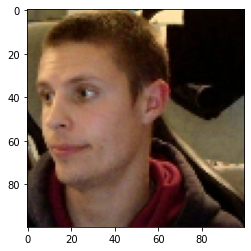

In [14]:
# *example unpacks all of the example images, then passes them through to preprocess_twin
res = preprocess_twin(*example)
len(res) 

plt.imshow(res[1])
res[2]

In [15]:
#### build dataLoader pipeline ####

# runs our preprocess_twin function on our data (contains the input_img and validation_img), and maps the data
data = data.map(preprocess_twin)
# caching our images so we can access them faster
data = data.cache()
# shuffles all our data
data = data.shuffle(buffer_size=1024)

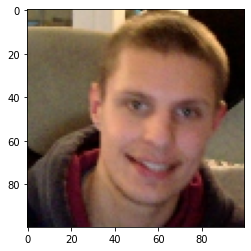

In [16]:
samples = data.as_numpy_iterator()
sample = samples.next()
# anchor image
plt.imshow(sample[0])


1.0


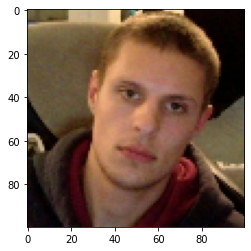

In [17]:
# negative or positive img
plt.imshow(sample[1])
# shows us the label (if it's a match or not)
print(sample[2])

In [18]:
#### training partition ####

# takes 70% of images for training data
train_data = data.take(round(len(data)*.7))
# changes our data to batches of 16
train_data = train_data.batch(16)
# starts preprocessing the next set of images so that we don't bottle neck our next set images
train_data = train_data.prefetch(8)

In [19]:
# now in the first index of our data we have 16 images
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [20]:
#### testing partition ####

# skipped first 70% of images which we used in train data
test_data = data.skip(round(len(data)*.7))
# then takes the rest of the 30% of data for testing
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

4.1 Build Embedding Layer

In [21]:
def make_embedding():
    input = Input(shape=(100,100,3), name="input_image")

    #### First block ####
    # convolution takes in number of filters we want to pass through, and the filter shape e.g 10x10
    c1 = Conv2D(64, (10,10), activation="relu")(input)
    # we again want 64, with the shape of 2x2, which condences down the amount of data. Padding=same replicates a similar output shape 
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)

    #### Second Block ####
    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    #### Third Block ####
    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    #### Final Embedding Block ####
    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    # takes all the outputs of our convolution layer (which is 3d) and flattens it to 2d
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    # model class comes from the TensorFlow library, it will compile all our layers into a model
    # it will ensure it takes our input, then goes through all our layers, and give it the name of embedding
    return Model(inputs=[input], outputs=[d1], name="embedding")

In [22]:
image2 = Image.open("deep_learning.png")
image2.show()

In [23]:

# this changes the input image down to the feature maps, as seen in the deep_learning screenshot. The shape has now changed after being passed through the convolution layer and now is in the max_pooling layer
input = Input(shape=(100,100,3), name="input_image")

c1 = Conv2D(64, (10,10), activation="relu")(input)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [24]:
# again has taken the image down to the next layer
m1 = MaxPooling2D(64, (2,2), padding="same")(c1)
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [25]:
#### Second Block ####
c2 = Conv2D(128, (7,7), activation="relu")(m1)
m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

#### Third Block ####
c3 = Conv2D(128, (4,4), activation="relu")(m2)
m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

c4 = Conv2D(256, (4,4), activation="relu")(m3)
# takes all the outputs of our convolution layer (which is 3d) and flattens it to 2d
f1 = Flatten()(c4)
d1 = Dense(4096, activation="sigmoid")(f1)


In [26]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [27]:
6*6*256

9216

In [28]:
# took our data to flatten all 9216 units of data into a single dimension
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [29]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [30]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

4.2 Build Distance Layer

In [31]:
class L1Dist(Layer):
    # **kwargs allows you to work with this specific layer as a part of the bigger model.
    def __init__(self, **kwargs):
        # performs inheritance on the function
        super().__init__()

    # calls tells the layer what to do when some data is passed through it
    # our two inputs are now going to combine
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

4.3 Make Siamese Model

In [32]:
def make_siamese_model():
    ## defines our two inputs
    # anchor image
    input_image = Input(name="input_img", shape=(100,100,3))
    # validation image
    validation_image = Input(name="validation_img", shape=(100,100,3))

    # Combines siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    

In [33]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

5.1 Setup Loss and Optimiser

In [34]:
# the loss will be used later to be able to calculate our loss (1 or 0)
binary_loss = tf.losses.BinaryCrossentropy()

In [35]:
# improves speed and performance
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish Checkpoints

In [36]:
# if something goes wrong we can go back 
# defined our checkpoint dir
checkpoint_dir = "./training_checkpoints"
# makes sure that all our checkpoints have the prefix of ckpt (stands for checkpoint)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# defined our checkpoint class
# esentially saves our the model and optimiser at the time we run the checkpoint class
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


5.3 Build Train Step Function

In [37]:
# What happens when we train on a single batchfunction

In [38]:
# compiles our function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    # allows us to capture our gradient from the model, records the operations for automatic differentiation
    # in short tape will record data, so that when we call it, we can take the data from the whole model
    # records all of our operations
    with tf.GradientTape() as tape:
        # get anchor and positive/negative images
        # remember when we defined our train data, we had a list containing [anchor, positive/negative, label]
        x = batch[:2]
        # gets the label
        y = batch[2]

        # forward pass
        # passes our data through the siamese model to make a prediction
        y_pred = siamese_model(x, training=True)
        # calculate loss
        # to calculate our loss we first pass through our y true value, so our label. Then we pass through our predicted value
        # the smaller the loss the closer our prediction is to the true labels (y_pred). 
        loss = binary_loss(y, y_pred)
    

        # calculate gradients
        # calculates all of the gradients in respect to our loss for all of our trainable variables
        # calculates all the graidients for our different wieghts within our specific model in respect to our loss
        grad = tape.gradient(loss, siamese_model.trainable_variables)

        # calculate updated weights and apply to siamese model
        # the optimiser is calculating and propagating the new weights using Adam's optimisation algorithm, a variant of gradient desecent
        # applying our learning rate and slightly reducing the loss by changing the weights to be closer to the optimiser.
        # 
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

5.4 Build Training Loop

In [39]:
def train(data, EPOCHS):
    # loop through the EPOCHS
    for epoch in range(1, EPOCHS+1):
        # will give how many we have looped through. e.g 4/50
        print(f"\n Epoch {epoch}/{EPOCHS}")
        progress_bar = tf.keras.utils.Progbar(len(data))

    # loop through each batch
    # gives a counter and the actual batch itself
    for index, batch in enumerate(data):
        # applying our train step function to a single batch
        train_step(batch)
        # updating our progress bar
        progress_bar.update(index+1)

    # save checkpoint
    # saves it every 10 epochs
    if epoch % 10 == 0: 
        checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the Model

In [41]:
EPOCHS = 1 # was 50
train(train_data, EPOCHS)


 Epoch 1/1
27/27 [==============================] - 409s 15s/step


# 6. Evaluate Model

6.1 Import metrics

In [42]:
# Precision: Computes the precision of the predictions with respect to the labels
# Recall: Computes the recall of the predictions with respect to the labels
# higher the number the better
# Precision demonstrates what proportion of positive identifications were actually correct
# Recall shows what proportion of actual positives were identified correctly
from tensorflow.keras.metrics import Precision, Recall


6.2 Make predictions

In [43]:
# get a batch of test data
# unpacks the data of each (test_input = input image, test_val = validation_image, y_true = labels)
test_input, test_validation, y_true = test_data.as_numpy_iterator().next() # converts our dataset as a numpy equivalent


In [44]:
# takes our test_data batch and turns into numpy. The .next gets the next batch of data looping through them all
test_var = test_data.as_numpy_iterator().next()

In [45]:
# len is 3 as input_image, positive/negative image, label
print(len(test_var))
# index 0 will be our input image
print("\n",test_var[0])
# as you can see the input images are in batches of 16
print("\n",len(test_var[0]))

3

 [[[[0.48921567 0.45784312 0.2764706 ]
   [0.49411765 0.45882353 0.29803923]
   [0.48210785 0.4490196  0.30637255]
   ...
   [0.07647059 0.05980392 0.02745098]
   [0.04215686 0.02254902 0.00490196]
   [0.07058824 0.03921569 0.03137255]]

  [[0.48333332 0.45784312 0.29313725]
   [0.4862745  0.4480392  0.30980393]
   [0.4745098  0.4392157  0.3156863 ]
   ...
   [0.0627451  0.04166667 0.01862745]
   [0.04289216 0.02328431 0.00612745]
   [0.05294118 0.03431373 0.02254902]]

  [[0.45759803 0.44583333 0.27720588]
   [0.45637256 0.4360294  0.2875    ]
   [0.45294118 0.42941177 0.2901961 ]
   ...
   [0.05808824 0.02818627 0.01397059]
   [0.05343137 0.03161765 0.01887255]
   [0.04705882 0.02843137 0.01666667]]

  ...

  [[0.08872549 0.07107843 0.09852941]
   [0.18039216 0.1620098  0.19166666]
   [0.1742647  0.15367647 0.18995099]
   ...
   [0.29558823 0.20833333 0.17720588]
   [0.32794118 0.23480392 0.19803922]
   [0.36764705 0.2754902  0.22941177]]

  [[0.10833333 0.09656863 0.12990196]
   

In [46]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [47]:
#model.predict([test_input, test_validation])
print(os.getcwd())
print(os.path.join("application_data", "input_image", "input_img.jpg"))
input2_img = preprocess(os.path.join("application_data", "input_image", "input_img.jpg"))
verification2_img = preprocess(os.path.join("application_data", "input_image", "verification_img.jpg"))
input2_img = input2_img.batch(16)
tf.reshape(input2_img, [])
print(test_input.shape)
print(input2_img.shape)
#siamese_model.predict([input_img, verification_img])

d:\Github\Siamese-neural-network\ai_model
application_data\input_image\input_img.jpg


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_img.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

In [48]:
# make predictions
print(test_var[2])
#print(test_var[1])
print(test_validation)
y_pred = siamese_model.predict([test_input, test_validation])
y_pred

[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.]
[[[[4.62500006e-01 4.18137252e-01 2.82352954e-01]
   [4.82598037e-01 4.44852948e-01 3.33823532e-01]
   [4.34068620e-01 4.03676480e-01 3.02696079e-01]
   ...
   [5.63725494e-02 2.45098043e-02 3.18627455e-03]
   [4.04411778e-02 2.23039221e-02 3.92156886e-03]
   [2.79411767e-02 1.96078438e-02 0.00000000e+00]]

  [[4.29166675e-01 3.87990206e-01 2.61519611e-01]
   [4.46323544e-01 4.12990183e-01 3.00245106e-01]
   [3.99264693e-01 3.71813715e-01 2.67892152e-01]
   ...
   [5.68627454e-02 1.47058824e-02 6.86274515e-03]
   [4.21568640e-02 8.82352982e-03 9.80392215e-04]
   [3.99509817e-02 1.96078438e-02 4.90196096e-03]]

  [[4.27450985e-01 3.89460772e-01 2.50490189e-01]
   [4.23039228e-01 3.90441179e-01 2.56862760e-01]
   [4.23284322e-01 3.96568626e-01 2.73284316e-01]
   ...
   [5.39215691e-02 9.55882389e-03 6.86274515e-03]
   [5.31862751e-02 1.39705883e-02 9.80392192e-03]
   [5.00000007e-02 1.27450982e-02 7.84313772e-03]]

  ...

  [[5.26960790e-

array([[0.8814603 ],
       [0.7799439 ],
       [0.00113492],
       [0.5807501 ],
       [0.938616  ],
       [0.02601638],
       [0.07145321],
       [0.9337965 ],
       [0.39034253],
       [0.00266993],
       [0.0062997 ],
       [0.0321967 ],
       [0.00103249],
       [0.18321642],
       [0.8499094 ],
       [0.8952279 ]], dtype=float32)

In [49]:
# post-processing the results
# if prediction is > 0.5, we want our result to add a 1
results = []
for prediction in y_pred:
    if prediction > 0.5:
        results.append(1)
    else:
        results.append(0)
results

[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]

In [50]:
y_true

array([1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

6.3 Calculating metrics

In [51]:
#### Compares the two pieces of data rather than looking at the two lists above
# creating a metric object
m = Recall()
# calculating the recall value
m.update_state(y_true, y_pred)
# returns the result
m = m.result().numpy()
m


1.0

In [52]:
m = Precision()
# calculating the recall value
m.update_state(y_true, y_pred)
# returns the result
m = m.result().numpy()
m

1.0

6.4 Visualise results

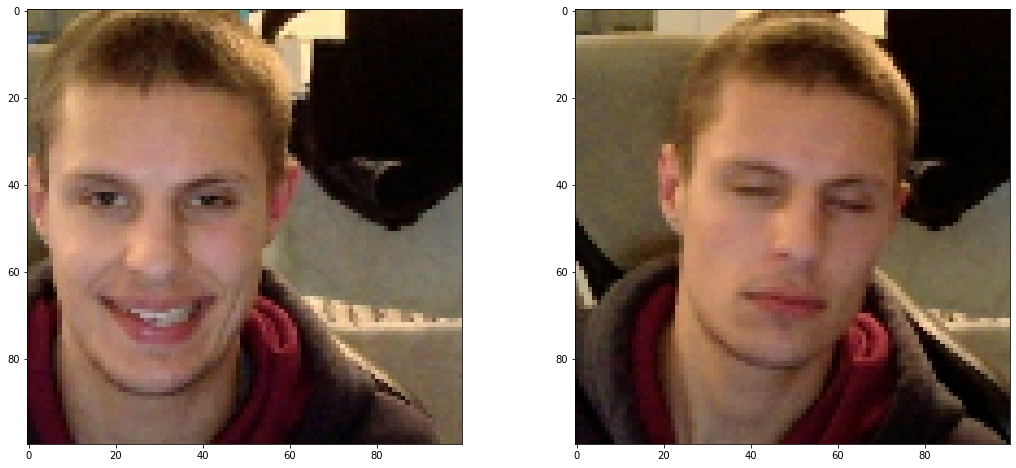

In [53]:
# can change array values to values in prediction to show predicted values are right
# figsize sets how big our plot is
plt.figure(figsize=(18,8))
# we are setting two images side by side
# the subplot function allows you to render plots using a grid like format. First number is rows, second  the columns, third the index (this image has 1, so our first image)
# so we've set two 1 row, and 2 columns, with the first image being first
plt.subplot(1,2,1)
plt.imshow(test_input[0])
# second image index number is 2 meaning it will be placed after the first, next to it as there is only one row
plt.subplot(1,2,2)
plt.imshow(test_validation[0])

# 7. Save Model

In [54]:
# because we created a custom layer, we're going to need to change it a bit so we can export it all
# h5 means our model weight
siamese_model.save("siamese_model.h5")

In [55]:
# reloads model
# first loads the file
#3.36.57 time for help when importing
# We're first passing through to our custom objects our L1Dist layer, then we want to pass through our BinaryCrossentropy, because we created a seperate key for
# the custom objects is creating a dictionary of name:class
L1Dist
model = tf.keras.models.load_model("siamese_model.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [56]:
# make predictions with reloaded model
#model.predict([test_input, test_validation])
#model.predict([test_input, test_validation])
input2_img = preprocess(os.path.join("application_data", "input_image", "input_img.jpg"))

verification2_img = preprocess(os.path.join("application_data", "input_image", "verification_img.jpg"))

siamese_model.predict([input_img, verification_img])

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_img.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

# 8. Real Time Test
3h 42 for explanation
we perform it on 50 images to give us a better guess, however can work on one
created application folder and input_images, verification_image folders with 50 images in verificaiton

8.1 Verification function

In [57]:
# detection threshold: metric which above a prediction is considered positive
# verification threshold: proportion of positive predictions / total samples
def verify(model, detection_threshold, verification_threshold):
    results = []
    # looping through all our images in our verification images
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_img.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))

        # np.expand_dims wraps an arrary inside another set of arrays, need to do this as we have one input_img. 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # take our results and wrap in numpy array, then sums up all of our results which pass our detection threshold
    detection = np.sum(np.array(results) > detection_threshold)
    # we need to find how many predictions we are making to find out the number of predictions passed
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    # returns a true or false if the verification is greater than the threshold. If greater, the person is verified 
    verified = verification > verification_threshold
    return results, verified 

8.2 OpenCV 

In [58]:
L1Dist
model = tf.keras.models.load_model("siamese_model.h5", custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [59]:
cap = cv2.VideoCapture(0)
cap.set(3, 250)
cap.set(4, 250)

while True:
    ret, frame = cap.read() # reads each frame one by one
    
    # create input_image
    if cv2.waitKey(1) & 0xFF == ord("c"):
        imname = os.path.join("application_data", "input_image", "input_img.jpg")
        cv2.imwrite(imname, frame)
        
        # verification function
        results, verified = verify(model, 0.7, 0.7)
        print(verified)

    cv2.imshow("verification", frame) # shows image 
    if cv2.waitKey(20) & 0xFF == 27: # allows keyboard press to close window with the escape key
        break

# when finished, release the capture
cap.release() 
cv2.destroyAllWindows()

In [60]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'application_data\\verification_images'

: 